<a href="https://colab.research.google.com/github/ibombonato/aicrowd-blitz-faceimages/blob/main/Detecto_Mask_Recognition_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Feb 22 11:58:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

![](https://images.aicrowd.com/raw_images/challenges/banner_file/1020/efe95338563ab47dda7e.png)

<h2><center> Getting Started with Mask Recognition Challenge</center></h2>

In this puzzle, we have detect mask type and bounding box of the mask from the image of human face. 

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be submitting the sample prediction directly in the required format.



 AIcrowd code utilities for downloading data for Language Classification


# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [2]:
!pip install detecto
!pip install pascal-voc-writer

In [3]:
!pip install aicrowd-cli

     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 7.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 170 kB 52.9 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 214 kB 17.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 51 kB 8.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 22.3.0
    Uninstalling pyzmq-22.3.0:
      Successfully uninstalled pyzmq-22.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have


## Login to AIcrowd ㊗¶


In [1]:
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/wlyIPhvvALvTBqfJkBT9ON4Ku75ss1spWi3fk43lexk
API Key valid
Gitlab access token valid
Saved details successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Download Dataset¶

We will create a folder name data and download the files there.


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

sample_submission.csv:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/318M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/137M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Diving in the dataset 🕵️‍♂️

In [5]:
import torch
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from tqdm.auto import tqdm
import shutil
import glob
from ast import literal_eval
tqdm.pandas()

## Diving in the dataset 🕵️‍♂️

In [6]:
train_images = 'data/train'
val_images = 'data/val'
test_images = 'data/test'

In [7]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [8]:
IMAGE_DIMS = (512, 512)

def format_bbox(annotation):
    xmin, ymin, xmax, ymax = annotation[0], annotation[1], annotation[2], annotation[3]
    width = xmax - xmin
    height = ymax - ymin
    return [{"xmin": xmin, "ymin": ymin, "width": width, "height": height}]

def make_df(df, path):
  df['bbox_list'] = [literal_eval(box) for box in df['bbox'].values]
  df['bbox_coco'] = df['bbox_list'].apply(lambda x: format_bbox(x)) 
  df['image']     = df['ImageID'].apply(lambda x: f"{path}/{x}.jpg")
  return df

In [9]:
train_df = make_df(train_df, "/content/data/train/train")

In [10]:
val_df = make_df(val_df, "/content/data/val/val")

In [11]:
train_df.head()

,ImageID,bbox,masktype,bbox_list,bbox_coco,image
0,k8o0f,"[73, 197, 293, 400]",N95,"[73, 197, 293, 400]","[{'xmin': 73, 'ymin': 197, 'width': 220, 'heig...",/content/data/train/train/k8o0f.jpg
1,7a0l9,"[47, 364, 300, 512]",surgical,"[47, 364, 300, 512]","[{'xmin': 47, 'ymin': 364, 'width': 253, 'heig...",/content/data/train/train/7a0l9.jpg
2,wfp7p,"[203, 221, 380, 403]",N95,"[203, 221, 380, 403]","[{'xmin': 203, 'ymin': 221, 'width': 177, 'hei...",/content/data/train/train/wfp7p.jpg
3,7qaw6,"[87, 210, 322, 385]",surgical,"[87, 210, 322, 385]","[{'xmin': 87, 'ymin': 210, 'width': 235, 'heig...",/content/data/train/train/7qaw6.jpg
4,i4kqj,"[227, 283, 479, 475]",surgical,"[227, 283, 479, 475]","[{'xmin': 227, 'ymin': 283, 'width': 252, 'hei...",/content/data/train/train/i4kqj.jpg


Detecto

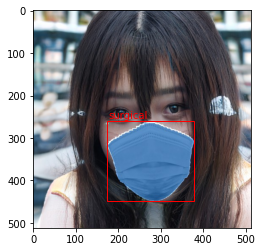

In [12]:
from detecto import utils, visualize, core
import random

#train_files, train_labels, train_bboxes = get_labels(train_df)
rand_int = random.randint(0, len(train_df))

boxes=torch.FloatTensor(train_df.iloc[rand_int]['bbox_list'])
image = utils.read_image(train_df.iloc[rand_int]['image'])
label = train_df.iloc[rand_int]['masktype']
visualize.show_labeled_image(image, boxes, label)


In [13]:
train_df.head()

,ImageID,bbox,masktype,bbox_list,bbox_coco,image
0,k8o0f,"[73, 197, 293, 400]",N95,"[73, 197, 293, 400]","[{'xmin': 73, 'ymin': 197, 'width': 220, 'heig...",/content/data/train/train/k8o0f.jpg
1,7a0l9,"[47, 364, 300, 512]",surgical,"[47, 364, 300, 512]","[{'xmin': 47, 'ymin': 364, 'width': 253, 'heig...",/content/data/train/train/7a0l9.jpg
2,wfp7p,"[203, 221, 380, 403]",N95,"[203, 221, 380, 403]","[{'xmin': 203, 'ymin': 221, 'width': 177, 'hei...",/content/data/train/train/wfp7p.jpg
3,7qaw6,"[87, 210, 322, 385]",surgical,"[87, 210, 322, 385]","[{'xmin': 87, 'ymin': 210, 'width': 235, 'heig...",/content/data/train/train/7qaw6.jpg
4,i4kqj,"[227, 283, 479, 475]",surgical,"[227, 283, 479, 475]","[{'xmin': 227, 'ymin': 283, 'width': 252, 'hei...",/content/data/train/train/i4kqj.jpg


In [14]:
from pascal_voc_writer import Writer

def create_voc(folder, df):
    files = glob.glob(folder+"/*")
    for i in range(len(files)):
        fid = files[i].replace(folder+'/','').split('.')[0]
        ldf=df[df['ImageID'] == fid].reset_index()
        if len(ldf)> 0:
            width, height = 512, 512
            writer = Writer(fid+'.jpg', width, height)
            for j in range(len(ldf)):
                writer.addObject(ldf['masktype'].iloc[j], 
                                 int(ldf['bbox_list'].iloc[j][0]), 
                                 int(ldf['bbox_list'].iloc[j][1]), 
                                 int(ldf['bbox_list'].iloc[j][2]),
                                 int(ldf['bbox_list'].iloc[j][3]))
            writer.save(folder+'/'+fid+'.xml')

In [15]:
create_voc("/content/data/train/train", train_df)
create_voc("/content/data/val/val", val_df)

In [16]:
LABELS = list(train_df['masktype'].unique())

In [17]:
LABELS

['N95', 'surgical', 'cloth', 'KN95']

In [18]:
dataset = core.Dataset('/content/data/train/train')
loader = core.DataLoader(dataset, batch_size=16, shuffle=True)
val_dataset = core.Dataset('/content/data/val/val')

In [20]:
CHECKPOINT_FILE = "/content/drive/MyDrive/models/face-mask-detection/detector-checkpoint/model_weights.pth"
IS_RETRAIN = True

In [21]:
if IS_RETRAIN:
  model = core.Model.load(CHECKPOINT_FILE, LABELS)
else:
  model = core.Model(LABELS)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
losses = model.fit(loader, val_dataset, epochs=5, learning_rate=0.001, lr_step_size=5, verbose=True)
print(losses)

Epoch 1 of 5
Begin iterating over training dataset


 27%|██▋       | 94/350 [02:54<07:58,  1.87s/it]

In [ ]:
model.save(CHECKPOINT_FILE)

In [22]:
image = utils.read_image(train_df.iloc[rand_int]['image'])
predictions = model.predict(image)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(['surgical'], tensor([[173.3350, 261.2303, 377.6056, 449.3160]]), tensor([0.9996]))


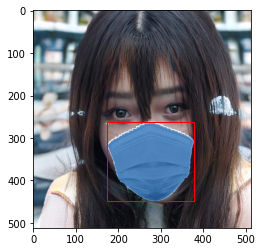

In [23]:
print(predictions)
visualize.show_labeled_image(image, predictions[1])

In [ ]:
tfiles = glob.glob("/content/data/test/test/*")
#tfiles= tfiles[-3:]
predf=pd.DataFrame(columns=['ImageID', 'bbox', 'masktype'])
no_counter = 0
for i in tqdm(range(len(tfiles))):
  image = utils.read_image(tfiles[i])
  fid = tfiles[i].replace("/content/data/test/test/",'').split('.')[0]
  predictions = model.predict(image)
  labels, boxes, scores = predictions
  if len(boxes) == 0:
    boxes = torch.Tensor([[0, 0 , 0, 0]])
    labels = ['N95']
    no_counter += 1
  predf=predf.append({'ImageID': fid, 'bbox': list(boxes[0].tolist()), 'masktype': labels[0]}, ignore_index=True)

In [ ]:
no_counter

In [ ]:
predf.head()

## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out here. 

In [ ]:
!rm -rf assets
!mkdir assets
predf.to_csv(os.path.join("assets", "submission.csv"), index=False)


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c mask-prediction -a assets --no-verify